In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD

import warnings; warnings.simplefilter('ignore')

In [6]:
df = pd.read_csv('Clean_listings.csv')

In [7]:
df.head()

,id,content,neighbourhood_group_cleansed,latitude,longitude,bathrooms,bedrooms,room_type,price,minimum_nights,number_of_reviews,review_scores_rating
0,2060,"Modern NYC // Lovely, spacious, sunny 1 BR apa...",Manhattan,40.85722,-73.93790,1.0,1.0,Private room,100.0,1,1,80.0
1,2595,"Skylit Midtown Castle // Beautiful, spacious s...",Manhattan,40.75362,-73.98377,1.0,0.0,Entire home/apt,225.0,7,48,94.0
2,3831,Cozy Entire Floor of Brownstone // Urban retre...,Brooklyn,40.68514,-73.95976,1.0,1.0,Entire home/apt,89.0,1,313,90.0
3,5099,Large Cozy 1 BR Apartment In Midtown East // M...,Manhattan,40.74767,-73.97500,1.0,1.0,Entire home/apt,200.0,3,78,90.0
4,5114,"Super Room in Great area. // First, the area i...",Manhattan,40.71910,-73.99040,1.0,1.0,Private room,94.0,1,75,94.0


In [6]:
# Check Null Values
df.isna().sum()

id                              0
content                         0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
bathrooms                       0
bedrooms                        0
room_type                       0
price                           0
minimum_nights                  0
number_of_reviews               0
review_scores_rating            0
dtype: int64

In [8]:
df.shape

(50796, 12)

In [9]:
listings_df = df['content']
listings_df.head()

0    Modern NYC // Lovely, spacious, sunny 1 BR apa...
1    Skylit Midtown Castle // Beautiful, spacious s...
2    Cozy Entire Floor of Brownstone // Urban retre...
3    Large Cozy 1 BR Apartment In Midtown East // M...
4    Super Room in Great area. // First, the area i...
Name: content, dtype: object

In [23]:
#subset of listings
few_listings_df = df.iloc[0:2000]
few_listings_df.shape

(2000, 12)

In [30]:
few_listings_df.head()

,id,content,neighbourhood_group_cleansed,latitude,longitude,bathrooms,bedrooms,room_type,price,minimum_nights,number_of_reviews,review_scores_rating
0,2060,"Modern NYC // Lovely, spacious, sunny 1 BR apa...",Manhattan,40.85722,-73.93790,1.0,1.0,Private room,100.0,1,1,80.0
1,2595,"Skylit Midtown Castle // Beautiful, spacious s...",Manhattan,40.75362,-73.98377,1.0,0.0,Entire home/apt,225.0,7,48,94.0
2,3831,Cozy Entire Floor of Brownstone // Urban retre...,Brooklyn,40.68514,-73.95976,1.0,1.0,Entire home/apt,89.0,1,313,90.0
3,5099,Large Cozy 1 BR Apartment In Midtown East // M...,Manhattan,40.74767,-73.97500,1.0,1.0,Entire home/apt,200.0,3,78,90.0
4,5114,"Super Room in Great area. // First, the area i...",Manhattan,40.71910,-73.99040,1.0,1.0,Private room,94.0,1,75,94.0


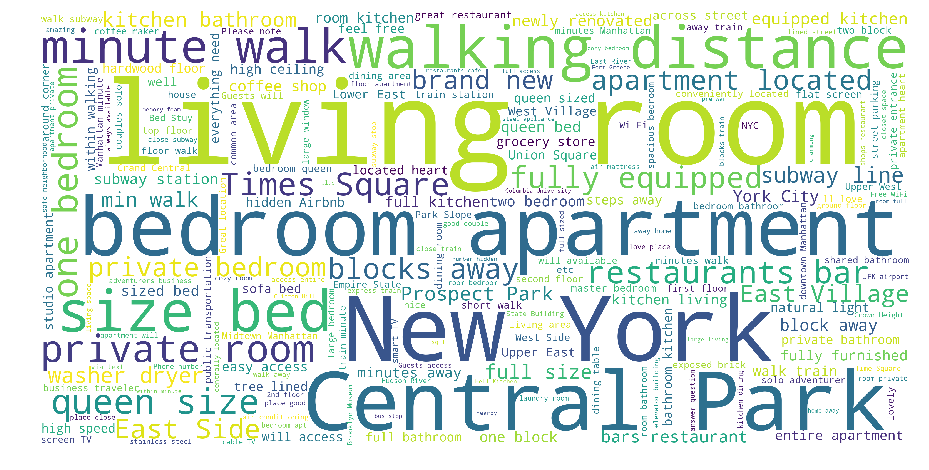

In [14]:
# WordCloud to display more frequently occured words in the listings and it can be used to choose a title
from wordcloud import WordCloud, STOPWORDS
description_corpus = ' '.join(df['content'])
name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

In [24]:
#Create a TF-IDF matrix of unigrams and bigrams for each listing
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(few_listings_df['content'])

In [25]:
tfidf_matrix.shape

(2000, 100470)

In [26]:
# Calculate Cosine Similarity between different listings
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [27]:
#Iterate through each similar listing and store the 100 most-similar!
results = {}
for idx, row in few_listings_df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], few_listings_df['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

In [38]:
#Function to get a friendly item name and description from the content field, given an item ID
def item(id):
    name   = few_listings_df.loc[few_listings_df['id'] == id]['content'].tolist()[0].split(' // ')[0]
    desc   = ' \nDescription: ' + few_listings_df.loc[few_listings_df['id'] == id]['content'].tolist()[0].split(' // ')[1][0:165] + '...'
    prediction = name  + desc
    return prediction

#Function to read the results out of the dictionary
def recommend(item_id, num):
    print('Recommending ' + str(num) + ' listings similar to ' + item(item_id))
    print('---')
    recs = results[item_id][:num]
    for rec in recs:
        print('\nRecommended: ' + item(rec[1]) + '\n(score:' + str(rec[0]) + ')')

In [39]:
recommend(item_id = 2595, num = 5)

Recommending 5 listings similar to Skylit Midtown Castle 
Description: Beautiful, spacious skylit studio in the heart of Midtown, Manhattan.  STUNNING SKYLIT STUDIO / 1 BED + SINGLE / FULL BATH / FULL KITCHEN / FIREPLACE / CENTRALLY LOC...
---

Recommended: Large Cozy 1 BR Apartment In Midtown East 
Description: My large 1 bedroom apartment has a true New York City feel.  The apt is in midtown on the east side and centrally located, just a 10-minute walk from Grand Central S...
(score:0.07397761780516834)

Recommended: Pied-à-Terre in Midtown Manhattan 
Description: A Pied-à-Terre in Manhattan Live like a New Yorker!!!  in this private Manhattan studio, with spacious courtyard views.  This calm and quiet, central East Side apart...
(score:0.07166360393228308)

Recommended: Perfect & Stylish Williamsburg Apt 
Description: Beautiful Italian venetian plaster walls, Large Industrial LOVE sign, Tall Ceilings, Apple TV, Full Kitchen, One of the hippest parts of New York City, called "Willi..